In [1]:
# Import all packages needed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import json
from pathlib import Path
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import style.json
style_path: Path = Path.cwd().parent / 'style' / 'style.json'
with open(style_path, 'r') as f:
    style = json.load(f)

In [3]:
# Loading Data (data file must be in the same directory as jupyter notebook)
# Import data from excel file
# TODO: replace filename with the name of your data file
raw_data_filename: str ='UV-Vis data - 2023_06_22_HWE-polymers-monomers.xlsx'

# Tell program to read the data
raw_data: pd.DataFrame = pd.read_excel(raw_data_filename)

# Output data
raw_data

,2023_06_22_C10-dialdehyde-chcl3,Unnamed: 1,2023_06_22_benzene-diphosphonate1,Unnamed: 3,2023_06_22_fluorene-diphosphonate,Unnamed: 5,2023_06_22_model-compound,Unnamed: 7,2023_06_22_AU-038-A2-3,Unnamed: 9,2023_06_22_AU-038-A3-2,Unnamed: 11,2023_06_22_AU-038-B1-2,Unnamed: 13,2023_06_22_AU-027-A4-2,Unnamed: 15
0,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs
1,700,-0.000736,700,0.000232,700,-0.000548,700,-0.000501,700,0.005895,700,0.001006,700,0.000726,700,0.001361
2,699.333313,-0.000776,699.333313,0.0002,699.333313,-0.000583,699.333313,-0.000495,699.333313,0.005836,699.333313,0.00094,699.333313,0.000706,699.333313,0.00134
3,698.666687,-0.000745,698.666687,0.000202,698.666687,-0.000557,698.666687,-0.000478,698.666687,0.005864,698.666687,0.000957,698.666687,0.000691,698.666687,0.001432
4,698,-0.000761,698,0.000205,698,-0.00058,698,-0.00045,698,0.005867,698,0.000935,698,0.000681,698,0.001356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,End Method Modifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,<Current Wavelength>,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,<SBW (nm)>,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
898,<Energy>,1819.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data preprocessing specific to UV-Vis
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(data: pd.DataFrame, normalize: bool = False, baseline: bool = False):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0)

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:")
    first_occurrence: int = indexes[indexes==0.0].index[0]
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0)

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2):
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs"
    data = data.rename(columns=column_rename)

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"})

    # Baseline correction
    if baseline:
        for col in data.columns:
            if "Abs" in col:
                data[col] = data[col] - np.average(data[col][0:50])

    # Normalize absorbance values
    if normalize:
        for col in data.columns:
            if "Abs" in col:
                max_val: float = data[col].max()
                data[col] = data[col] / max_val
    return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data: pd.DataFrame = preprocess(raw_data, True, True)
preprocessed_data

,Wavelength (nm),2023_06_22_C10-dialdehyde-chcl3_Abs,2023_06_22_benzene-diphosphonate1,2023_06_22_benzene-diphosphonate1_Abs,2023_06_22_fluorene-diphosphonate,2023_06_22_fluorene-diphosphonate_Abs,2023_06_22_model-compound,2023_06_22_model-compound_Abs,2023_06_22_AU-038-A2-3,2023_06_22_AU-038-A2-3_Abs,2023_06_22_AU-038-A3-2,2023_06_22_AU-038-A3-2_Abs,2023_06_22_AU-038-B1-2,2023_06_22_AU-038-B1-2_Abs,2023_06_22_AU-027-A4-2,2023_06_22_AU-027-A4-2_Abs
1,700,-0.000057,700,0.002557,700,0.000104,700,0.000059,700,-0.004242,700,0.000386,700,0.000079,700,0.000001
2,699.333313,-0.000174,699.333313,0.001214,699.333313,0.000043,699.333313,0.00009,699.333313,-0.004637,699.333313,-0.000031,699.333313,-0.000018,699.333313,-0.000091
3,698.666687,-0.000081,698.666687,0.001281,698.666687,0.000087,698.666687,0.000178,698.666687,-0.00445,698.666687,0.000076,698.666687,-0.000093,698.666687,0.000301
4,698,-0.000129,698,0.001407,698,0.000048,698,0.00032,698,-0.004425,698,-0.000062,698,-0.00014,698,-0.000021
5,697.333313,-0.000269,697.333313,0.000047,697.333313,-0.000016,697.333313,-0.000134,697.333313,-0.004467,697.333313,-0.000223,697.333313,-0.000411,697.333313,-0.000217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,242.666656,0.04407,242.666656,0.439337,242.666656,0.225011,242.666656,0.203322,242.666656,0.221223,242.666656,0.148253,242.666656,0.13162,242.666656,0.235074
688,241.999985,0.047048,241.999985,0.436899,241.999985,0.228806,241.999985,0.20092,241.999985,0.20439,241.999985,0.129341,241.999985,0.129547,241.999985,0.237177
689,241.333313,0.04521,241.333313,0.501564,241.333313,0.242591,241.333313,0.202196,241.333313,0.197467,241.333313,0.129814,241.333313,0.128459,241.333313,0.242227
690,240.666656,0.049826,240.666656,0.630697,240.666656,0.256312,240.666656,0.207306,240.666656,0.200007,240.666656,0.119244,240.666656,0.13637,240.666656,0.250021


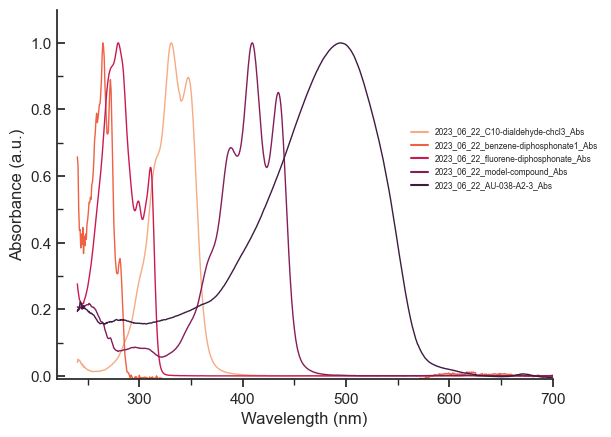

In [5]:
# Plot the data!
# NOTE: User must change the sample names to the correct column names.
sample_name_to_plot: list[str] = [
    "2023_06_22_C10-dialdehyde-chcl3_Abs",
    "2023_06_22_benzene-diphosphonate1_Abs",
    "2023_06_22_fluorene-diphosphonate_Abs",
    "2023_06_22_model-compound_Abs",
    "2023_06_22_AU-038-A2-3_Abs",
]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(
    preprocessed_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Absorbance (a.u.)",
)

# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Absorbance (a.u.)": "float32"}
)

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook")
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data,
    x="Wavelength (nm)",
    y="Absorbance (a.u.)",
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["line_thickness"],
)
sns.despine()

graph.legend(
    fontsize=style["legend"]["font_size"],
    bbox_to_anchor=(0.7, 0.7),
    title_fontsize=18,
    shadow=False,
    frameon=False,
)
# font family
plt.rcParams['font.family'] = style["graph"]["font_family"]

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2))
graph.yaxis.set_minor_locator(AutoMinorLocator(2))
graph.tick_params(axis="y", direction="in")
graph.tick_params(axis="y", which="minor", length=4, direction="in")
graph.tick_params(axis="x", which="minor", length=4, direction="out")

# NOTE: User can change the x and y limits here
plt.xlim(220, 700)
# NOTE: User can change the y limits here
plt.ylim(-0.01, 1.1)

plt.show()